# Example 3a: Rotational trap - Training of DeepCalib

Example code to train DeepCallib to determine the stiffness and the rotational component of a Brownian particle system in a non-conservative potential.

<strong>DeepCalib 1.0</strong><br/>
Enhanced force-field calibration via machine learning<br/>
version 1.0 - 27 April 2020<br/>
© Aykut Argun, Tobias Thalheim, Stefano Bo, Frank Cichos & Giovanni Volpe <br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INIZIALIZATION

In [1]:
import DeepCalib

%matplotlib inline
from numpy import log10
from numpy import log
from numpy import exp
from math import pi


## 2. DEFINE TRAJECTORY SIMULATION 
<a id="sec2"></a>

Here the function that simulates the motion of the Brownian particle in the force field under consideration is defined. Specifically, in this case, we consider a Brownian particle in a rotational force field, and the motion of the particle depends on the the trap radial component k and the rotational component M.

This file is used to reproduce results that are shown in the numerical section of Fig.5 and generate the pretrained network "Network_Example_3a" that is going to be needed to execute Example 3b.

Comments:
1. The function that simulates the trajectories must be called <strong>simulate_trajectory</strong>.
2. Lambda functions <strong>scale_inputs</strong>, <strong>rescale_inputs</strong>, <strong>scale_targets</strong>, and <strong>rescale_targets</strong> must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [11]:
### Physical parameters 
R = 1e-7                   # Radius of the Brownian particle [m]
eta = 0.001                # Viscosity of the medium [kg m^-1 s^-1]
T = 300                    # Temperature [K]
k0 = 20                    # Reference stiffness [fN m^-1]
M0 = 20                    # Reference rotational coefficient [N m^-1]
gamma0 = 1.3 * 6 * pi * eta * R  # Reference friction coefficient [kg s^-1]

### Simulation parameters
N = 1000                   # Number of samples of the trajectory
Dt = 5e-2                  # Timestep 
dt = 5e-3
oversampling = int(Dt/dt)          # Simulation oversampling
t_eq = 10*gamma0/k0
offset = int(t_eq/dt)              # Number of equilibration points

### Define functions to scale and rescale inputs
scale_inputs = lambda x, y: [x * 1e+6, y * 1e+6]     # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x: [scaled_x * 1e-6,
                                   scaled_y * 1e-6]  # Rescales input trajectory to physical units


### Define function to scale and rescale targets
scale_targets = lambda k, M: [log(k / k0), 
                              M/M0]                        # Scales targets to order 1
rescale_targets = lambda scaled_k, scaled_M: [exp(scaled_k) * k0, 
                                              scaled_M*M0] # Inverse of targets_scaling

### Define the simulate_trajectory function

def simulate_trajectory(batch_size=32,
                        T=T,
                        k0=k0,
                        M0=M0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset, 
                        scale_inputs=scale_inputs, 
                        scale_targets=scale_targets):
    
    """Simulates a Brownian particle in a rotational trap
    
    Inputs:
    
    T:              temperature of the environment
    k0:             center of the radial component range
    M0:             center of the rotational component range
    gamma0:         friction coefficient
    N:              number of trajectory data points
    Dt:             measurement period
    oversampling:   oversampling from the simulation time step (to calculate dt)
    offset:         steps of the simulation before starting to save the trajectory
    scale_inputs:   inputs scale function for the network, to normalize it comparable to 1 
    scale_targets:  targets scale function for the network, to normalize it comparable to 1
        
    Outputs:
    
    inputs: the inputs for the network, these are trajectories that have the following features: 
            
            inputs.names:          names of the input trajectory variables ('x', 'y' etc)
            inputs.values:         values of the inputs in SI units
            inputs.scalings:       short description of the scaling function for the inputs ('x*1e6' etc)
            inputs.scaled_values:  scaled values of the inputs to be passed to the network for training
            
    targets: the expected ground truth measurements for the trajectory that have following features: 
            
            targets.names:          names of the targets to be measures ('k' etc)
            targets.values:         values of the ground truth targets in SI units
            targets.scalings:       short description of the scaling function for the targets ('log(k/k0)' etc)
            targets.scaled_values:  scaled values of the ground truth targets to be passed to the network for training      
    """      

    import numpy as np
    from scipy.constants import Boltzmann as kB
    from math import pi
    from math import sqrt
    from numpy.random import randn as gauss
    from numpy.random import rand as uniform
   
    ### Randomize trajectory parameters
    
    k = k0 * 10**(uniform(batch_size)*2 - 1) 
    M = M0 * (uniform(batch_size)*5 -2.5)
    gamma = gamma0 * (uniform(batch_size)*0.2 + .9)    
    
    ### Simulate
    
    dt = Dt / oversampling
    x = np.zeros((batch_size, N))
    y = np.zeros((batch_size, N))
    D = kB * T / gamma
    C1 = -k * 1e-9 / gamma * dt
    C2 = -M * 1e-9 / gamma * dt
    C3 = np.sqrt(2 * D * dt)
    
    X = x[:,0]
    Y = y[:,0]
    n = 0
    
    for t in range(offset):                      # Offset  
        
        X = X + C1 * X - C2 * Y + C3 * gauss(batch_size)
        Y = Y + C1 * Y + C2 * X + C3 * gauss(batch_size) 
        
    for t in range(N * oversampling):            # Simulation                
        X = X + C1 * X - C2 * Y + C3 * gauss(batch_size)
        Y = Y + C1 * Y + C2 * X + C3 * gauss(batch_size) 
        if t % oversampling == 0:
            x[:,n] = X 
            y[:,n] = Y
            n += 1
    
    # Normalize trajectory and targets
    
    inputs = DeepCalib.trajectory(
        names=['x', 'y'],
        values=np.swapaxes([x, y],0,1),  
        scalings=['x [\u03BCm]', 'y [\u03BCm]'],  
        scaled_values=np.swapaxes(scale_inputs(*[x,y]),0,1))
    
    targets = DeepCalib.targets(
        names=['k [fN/\u03BCm]', 'M [fN/\u03BCm]'], 
        values=np.swapaxes([k, M],0,1),
        scalings=['log(k/k0)', 'M/M0'], 
        scaled_values=np.swapaxes(scale_targets(*[k, M]),0,1))    
    
    return inputs, targets

## 3. CHECK TRAJECTORY SIMULATION

Checks the results of the function to simulate the trajectories by plotting some examples in rescaled units. 

Have a look at the trajectories and check if they match your system, and keep an eye on different trajectories and make sure your scaled units vary in the order of 1, i.e, neither too small (0.01 or smaller) nor too large (100 or larger)

The parameter <strong>number_of_images_to_show</strong> determines the number of trajectories that are plotted.

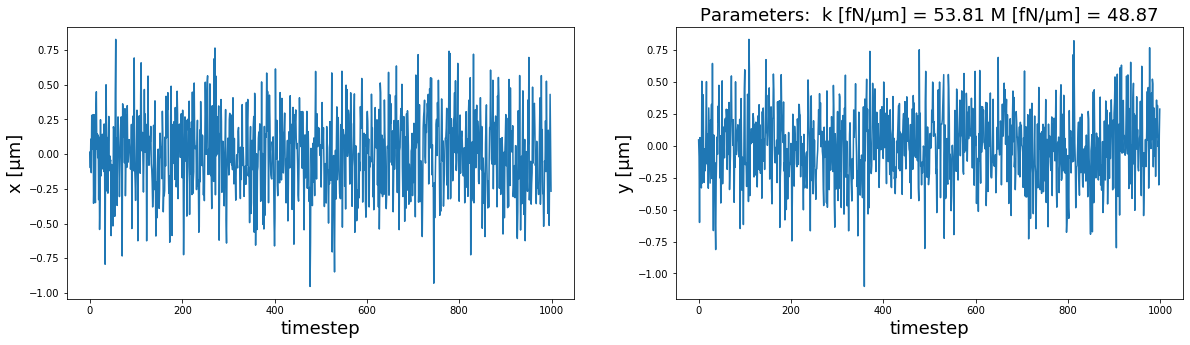

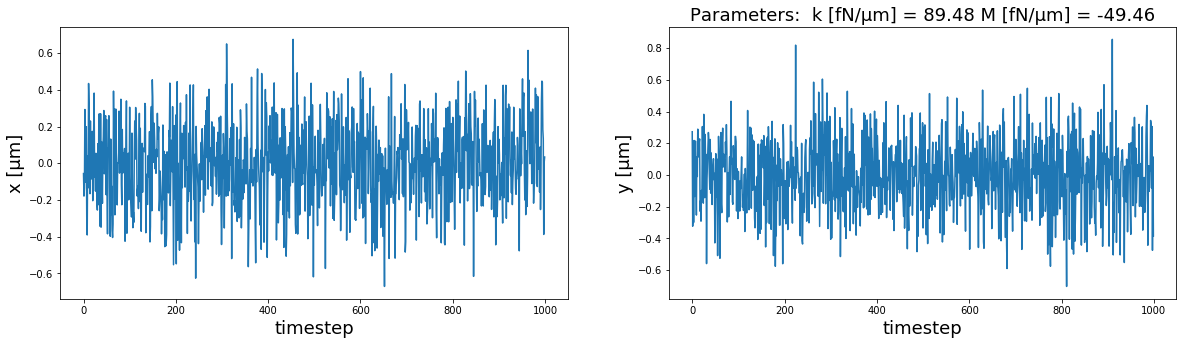

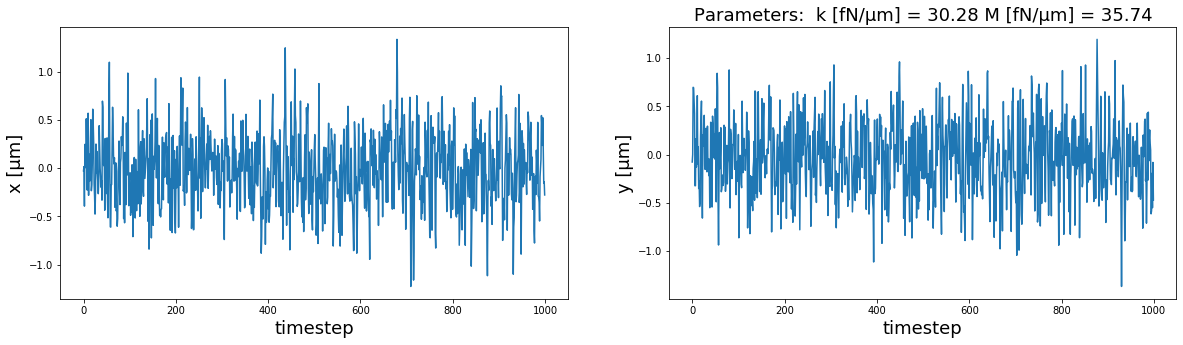

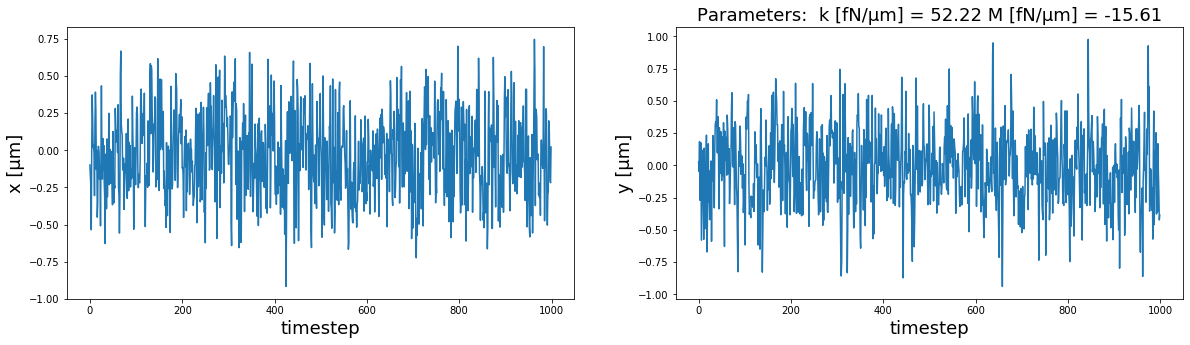

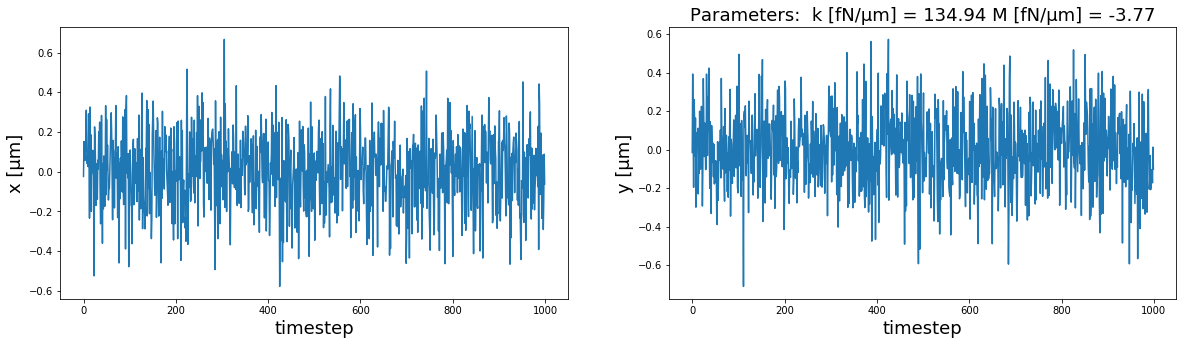

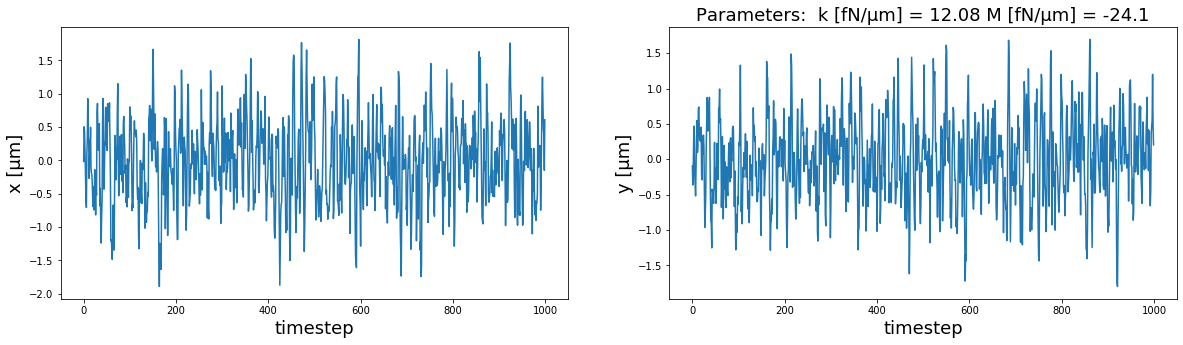

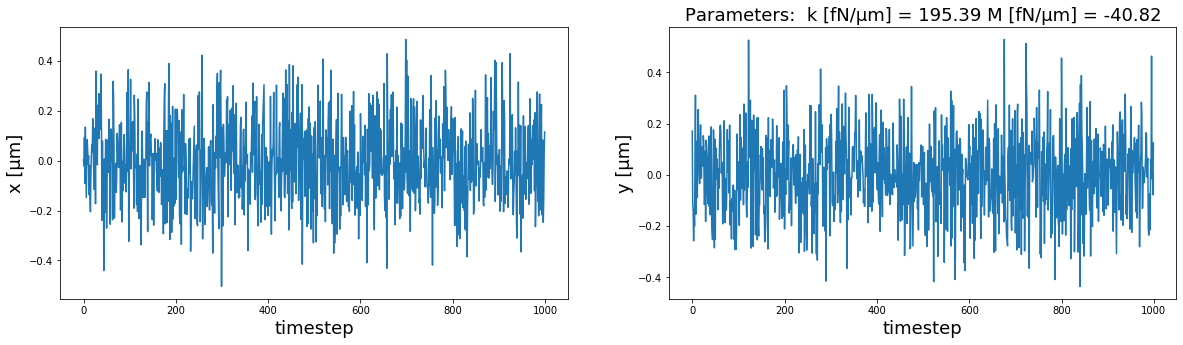

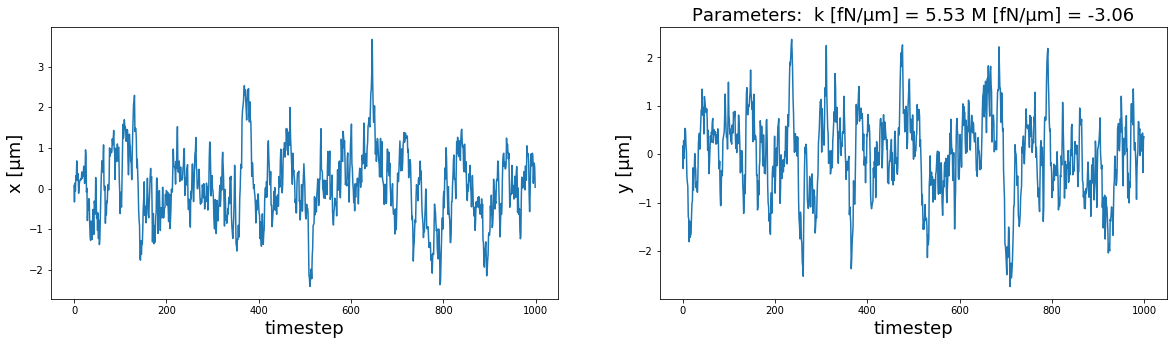

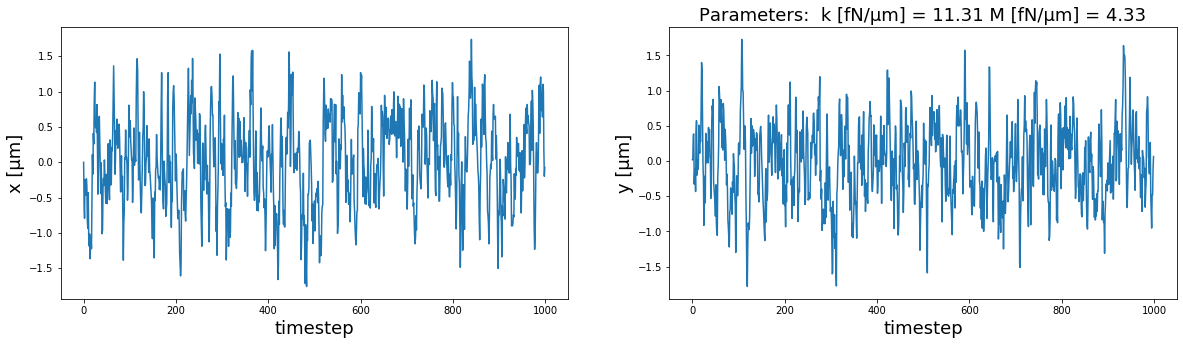

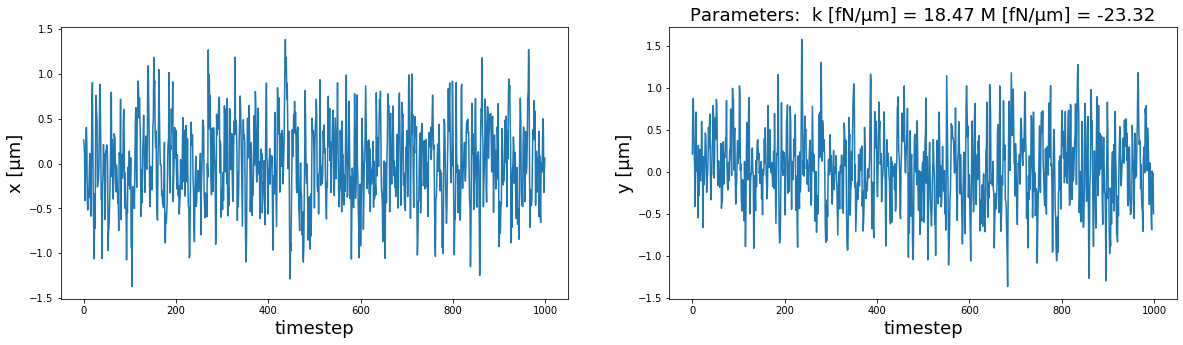

In [12]:
### Show some examples of simulated trajectories

number_of_trajectories_to_show = 10
DeepCalib.plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

## 4. CREATE AND COMPILE DEEP LEARNING NETWORK

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.  

Comments:
1. The parameter <strong>input_shape</strong> determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 1000 = 2000.
2. The parmameter <strong>conv_layers_dimensions</strong> determines the number and size of LSTM layers.
3. The parameter <strong>number_of_outputs</strong> determines the number of outputs, i.e. the number of force field parameters to be estimated.

In [3]:
### Define parameters of the deep learning network

input_shape = (None, 1000)      
lstm_layers_dimensions = (1000, 250, 50)
number_of_outputs = 2

### Create deep learning network

network = DeepCalib.create_deep_learning_network(input_shape, lstm_layers_dimensions, number_of_outputs)

### Print deep learning network summary

network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 1000)        8004000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 250)         1251000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                60200     
_________________________________________________________________
output (Dense)               (None, 2)                 102       
Total params: 9,315,302
Trainable params: 9,315,302
Non-trainable params: 0
_________________________________________________________________


## 5. TRAIN DEEP LEARNING NETWORK

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:
1. The parameter <strong>sample_sizes</strong> determines the sizes of the batches of trajectories used in the training.
2. The parameter <strong>iteration_numbers</strong> determines the numbers of batches used in the training.
3. The parameter <strong>verbose</strong> determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [7]:
### Define parameters of the training

sample_sizes = (32, 128, 512, 2048, 4096)
iteration_numbers = (1001, 1001, 3001, 3001, 4001)
verbose = .1

### Training
training_history = DeepCalib.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size     32   iteration number      1   MSE     2.0823   MAE     1.2505   Time 5093.000174 ms
Sample size     32   iteration number     11   MSE     2.2608   MAE     1.2924   Time 109.430075 ms
Sample size     32   iteration number     21   MSE     1.8955   MAE     1.1855   Time 113.164186 ms
Sample size     32   iteration number     31   MSE     1.7062   MAE     1.1150   Time 113.186598 ms
Sample size     32   iteration number     41   MSE     1.5079   MAE     1.0190   Time 108.441114 ms
Sample size     32   iteration number     51   MSE     1.6076   MAE     1.0865   Time 108.117104 ms
Sample size     32   iteration number     61   MSE     1.3837   MAE     0.9438   Time 109.647036 ms
Sample size     32   iteration number     71   MSE     1.2544   MAE     0.9123   Time 110.501051 ms
Sample size     32   iteration number     81   MSE     1.2242   MAE     0.8445   Time 112.050295 ms
Sample size     32   iteration number     91   MSE     0.7453   MAE     0.6822   Time 110.431433 ms

Sample size     32   iteration number    821   MSE     0.7520   MAE     0.5404   Time 113.027573 ms
Sample size     32   iteration number    831   MSE     0.4925   MAE     0.4270   Time 116.530895 ms
Sample size     32   iteration number    841   MSE     0.2779   MAE     0.3154   Time 114.154816 ms
Sample size     32   iteration number    851   MSE     0.4882   MAE     0.4329   Time 108.955145 ms
Sample size     32   iteration number    861   MSE     0.3731   MAE     0.3927   Time 111.850977 ms
Sample size     32   iteration number    871   MSE     0.4192   MAE     0.4222   Time 108.568192 ms
Sample size     32   iteration number    881   MSE     0.2489   MAE     0.3046   Time 109.184742 ms
Sample size     32   iteration number    891   MSE     0.5419   MAE     0.4387   Time 108.220577 ms
Sample size     32   iteration number    901   MSE     0.3456   MAE     0.3596   Time 106.255531 ms
Sample size     32   iteration number    911   MSE     0.5912   MAE     0.4746   Time 109.645128 ms


Sample size    128   iteration number    631   MSE     0.2607   MAE     0.2726   Time 174.374580 ms
Sample size    128   iteration number    641   MSE     0.3466   MAE     0.3445   Time 173.374414 ms
Sample size    128   iteration number    651   MSE     0.3247   MAE     0.3046   Time 177.472591 ms
Sample size    128   iteration number    661   MSE     0.2680   MAE     0.2750   Time 178.392410 ms
Sample size    128   iteration number    671   MSE     0.2627   MAE     0.2868   Time 174.498320 ms
Sample size    128   iteration number    681   MSE     0.2263   MAE     0.2821   Time 173.217297 ms
Sample size    128   iteration number    691   MSE     0.2296   MAE     0.2632   Time 174.723864 ms
Sample size    128   iteration number    701   MSE     0.3216   MAE     0.3119   Time 174.172163 ms
Sample size    128   iteration number    711   MSE     0.2665   MAE     0.2740   Time 176.882505 ms
Sample size    128   iteration number    721   MSE     0.3873   MAE     0.3267   Time 176.260233 ms


Sample size    512   iteration number    441   MSE     0.2558   MAE     0.2574   Time 413.565636 ms
Sample size    512   iteration number    451   MSE     0.2046   MAE     0.2349   Time 423.625946 ms
Sample size    512   iteration number    461   MSE     0.2319   MAE     0.2365   Time 409.314632 ms
Sample size    512   iteration number    471   MSE     0.2678   MAE     0.2611   Time 409.840107 ms
Sample size    512   iteration number    481   MSE     0.1783   MAE     0.2143   Time 397.422552 ms
Sample size    512   iteration number    491   MSE     0.2056   MAE     0.2251   Time 423.063040 ms
Sample size    512   iteration number    501   MSE     0.2391   MAE     0.2504   Time 410.950899 ms
Sample size    512   iteration number    511   MSE     0.2052   MAE     0.2316   Time 409.921885 ms
Sample size    512   iteration number    521   MSE     0.1614   MAE     0.2108   Time 425.201893 ms
Sample size    512   iteration number    531   MSE     0.1926   MAE     0.2226   Time 410.829544 ms


Sample size    512   iteration number   1261   MSE     0.1923   MAE     0.2183   Time 409.927845 ms
Sample size    512   iteration number   1271   MSE     0.1586   MAE     0.2039   Time 421.897173 ms
Sample size    512   iteration number   1281   MSE     0.1770   MAE     0.2131   Time 411.184072 ms
Sample size    512   iteration number   1291   MSE     0.1948   MAE     0.2180   Time 409.529924 ms
Sample size    512   iteration number   1301   MSE     0.1588   MAE     0.2047   Time 397.067785 ms
Sample size    512   iteration number   1311   MSE     0.2615   MAE     0.2500   Time 398.835659 ms
Sample size    512   iteration number   1321   MSE     0.1775   MAE     0.2103   Time 408.262014 ms
Sample size    512   iteration number   1331   MSE     0.2120   MAE     0.2220   Time 397.435904 ms
Sample size    512   iteration number   1341   MSE     0.1740   MAE     0.2065   Time 409.893274 ms
Sample size    512   iteration number   1351   MSE     0.2207   MAE     0.2277   Time 409.484863 ms


Sample size    512   iteration number   2081   MSE     0.1451   MAE     0.1940   Time 408.243895 ms
Sample size    512   iteration number   2091   MSE     0.1558   MAE     0.2005   Time 409.772396 ms
Sample size    512   iteration number   2101   MSE     0.1786   MAE     0.2064   Time 396.480322 ms
Sample size    512   iteration number   2111   MSE     0.1962   MAE     0.2182   Time 425.505400 ms
Sample size    512   iteration number   2121   MSE     0.1568   MAE     0.1969   Time 411.452770 ms
Sample size    512   iteration number   2131   MSE     0.1816   MAE     0.2083   Time 407.827854 ms
Sample size    512   iteration number   2141   MSE     0.1968   MAE     0.2175   Time 422.307730 ms
Sample size    512   iteration number   2151   MSE     0.1865   MAE     0.2105   Time 394.309282 ms
Sample size    512   iteration number   2161   MSE     0.1743   MAE     0.2110   Time 410.778999 ms
Sample size    512   iteration number   2171   MSE     0.1778   MAE     0.2090   Time 393.244743 ms


Sample size    512   iteration number   2901   MSE     0.1899   MAE     0.2183   Time 411.709785 ms
Sample size    512   iteration number   2911   MSE     0.1880   MAE     0.2165   Time 406.205654 ms
Sample size    512   iteration number   2921   MSE     0.1704   MAE     0.2093   Time 425.517321 ms
Sample size    512   iteration number   2931   MSE     0.2118   MAE     0.2233   Time 411.635399 ms
Sample size    512   iteration number   2941   MSE     0.2270   MAE     0.2255   Time 407.879591 ms
Sample size    512   iteration number   2951   MSE     0.2035   MAE     0.2216   Time 410.937309 ms
Sample size    512   iteration number   2961   MSE     0.1834   MAE     0.2050   Time 409.693003 ms
Sample size    512   iteration number   2971   MSE     0.1683   MAE     0.2057   Time 412.298679 ms
Sample size    512   iteration number   2981   MSE     0.1432   MAE     0.1903   Time 408.653021 ms
Sample size    512   iteration number   2991   MSE     0.1335   MAE     0.1832   Time 409.659386 ms


Sample size   2048   iteration number    711   MSE     0.1513   MAE     0.1869   Time 1286.361933 ms
Sample size   2048   iteration number    721   MSE     0.1462   MAE     0.1831   Time 1280.916214 ms
Sample size   2048   iteration number    731   MSE     0.1657   MAE     0.1909   Time 1287.539244 ms
Sample size   2048   iteration number    741   MSE     0.1318   MAE     0.1762   Time 1283.987522 ms
Sample size   2048   iteration number    751   MSE     0.1463   MAE     0.1833   Time 1295.931101 ms
Sample size   2048   iteration number    761   MSE     0.1392   MAE     0.1826   Time 1288.852692 ms
Sample size   2048   iteration number    771   MSE     0.1389   MAE     0.1791   Time 1289.319754 ms
Sample size   2048   iteration number    781   MSE     0.1533   MAE     0.1860   Time 1290.032625 ms
Sample size   2048   iteration number    791   MSE     0.1501   MAE     0.1859   Time 1295.710802 ms
Sample size   2048   iteration number    801   MSE     0.1501   MAE     0.1863   Time 1288.

Sample size   2048   iteration number   1531   MSE     0.1574   MAE     0.1898   Time 1286.020041 ms
Sample size   2048   iteration number   1541   MSE     0.1466   MAE     0.1867   Time 1293.138981 ms
Sample size   2048   iteration number   1551   MSE     0.1311   MAE     0.1709   Time 1289.965153 ms
Sample size   2048   iteration number   1561   MSE     0.1408   MAE     0.1798   Time 1280.943394 ms
Sample size   2048   iteration number   1571   MSE     0.1366   MAE     0.1748   Time 1283.660412 ms
Sample size   2048   iteration number   1581   MSE     0.1337   MAE     0.1763   Time 1286.876202 ms
Sample size   2048   iteration number   1591   MSE     0.1460   MAE     0.1817   Time 1288.401365 ms
Sample size   2048   iteration number   1601   MSE     0.1496   MAE     0.1831   Time 1292.370081 ms
Sample size   2048   iteration number   1611   MSE     0.1191   MAE     0.1685   Time 1285.511017 ms
Sample size   2048   iteration number   1621   MSE     0.1439   MAE     0.1810   Time 1299.

Sample size   2048   iteration number   2351   MSE     0.1225   MAE     0.1692   Time 1284.106731 ms
Sample size   2048   iteration number   2361   MSE     0.1227   MAE     0.1741   Time 1285.101652 ms
Sample size   2048   iteration number   2371   MSE     0.1280   MAE     0.1754   Time 1356.327295 ms
Sample size   2048   iteration number   2381   MSE     0.1406   MAE     0.1797   Time 1289.225578 ms
Sample size   2048   iteration number   2391   MSE     0.1485   MAE     0.1821   Time 1291.010857 ms
Sample size   2048   iteration number   2401   MSE     0.1403   MAE     0.1793   Time 1288.707495 ms
Sample size   2048   iteration number   2411   MSE     0.1358   MAE     0.1764   Time 1292.578697 ms
Sample size   2048   iteration number   2421   MSE     0.1353   MAE     0.1797   Time 1294.742823 ms
Sample size   2048   iteration number   2431   MSE     0.1283   MAE     0.1773   Time 1289.381027 ms
Sample size   2048   iteration number   2441   MSE     0.1312   MAE     0.1785   Time 1296.

Sample size   4096   iteration number    161   MSE     0.1325   MAE     0.1723   Time 2528.827190 ms
Sample size   4096   iteration number    171   MSE     0.1250   MAE     0.1675   Time 2537.225246 ms
Sample size   4096   iteration number    181   MSE     0.1287   MAE     0.1703   Time 2520.460844 ms
Sample size   4096   iteration number    191   MSE     0.1226   MAE     0.1677   Time 2517.059565 ms
Sample size   4096   iteration number    201   MSE     0.1279   MAE     0.1699   Time 2526.288509 ms
Sample size   4096   iteration number    211   MSE     0.1390   MAE     0.1730   Time 2524.494171 ms
Sample size   4096   iteration number    221   MSE     0.1242   MAE     0.1709   Time 2518.636227 ms
Sample size   4096   iteration number    231   MSE     0.1220   MAE     0.1664   Time 2512.130022 ms
Sample size   4096   iteration number    241   MSE     0.1132   MAE     0.1617   Time 2513.323307 ms
Sample size   4096   iteration number    251   MSE     0.1191   MAE     0.1667   Time 2507.

Sample size   4096   iteration number    981   MSE     0.1221   MAE     0.1666   Time 2508.379221 ms
Sample size   4096   iteration number    991   MSE     0.1112   MAE     0.1628   Time 2517.844915 ms
Sample size   4096   iteration number   1001   MSE     0.1109   MAE     0.1592   Time 2522.248983 ms
Sample size   4096   iteration number   1011   MSE     0.1137   MAE     0.1616   Time 2517.416954 ms
Sample size   4096   iteration number   1021   MSE     0.1138   MAE     0.1640   Time 2510.916233 ms
Sample size   4096   iteration number   1031   MSE     0.1221   MAE     0.1689   Time 2512.394667 ms
Sample size   4096   iteration number   1041   MSE     0.1197   MAE     0.1658   Time 2515.746593 ms
Sample size   4096   iteration number   1051   MSE     0.1286   MAE     0.1720   Time 2511.249304 ms
Sample size   4096   iteration number   1061   MSE     0.1101   MAE     0.1595   Time 2515.509129 ms
Sample size   4096   iteration number   1071   MSE     0.1152   MAE     0.1628   Time 2518.

Sample size   4096   iteration number   1801   MSE     0.1230   MAE     0.1680   Time 2573.099136 ms
Sample size   4096   iteration number   1811   MSE     0.1125   MAE     0.1626   Time 2569.129467 ms
Sample size   4096   iteration number   1821   MSE     0.1070   MAE     0.1602   Time 2578.104019 ms
Sample size   4096   iteration number   1831   MSE     0.1128   MAE     0.1612   Time 2567.136526 ms
Sample size   4096   iteration number   1841   MSE     0.1091   MAE     0.1620   Time 2565.142155 ms
Sample size   4096   iteration number   1851   MSE     0.1215   MAE     0.1696   Time 2580.101728 ms
Sample size   4096   iteration number   1861   MSE     0.1146   MAE     0.1644   Time 2588.080168 ms
Sample size   4096   iteration number   1871   MSE     0.1224   MAE     0.1679   Time 2569.129705 ms
Sample size   4096   iteration number   1881   MSE     0.1143   MAE     0.1636   Time 2576.114655 ms
Sample size   4096   iteration number   1891   MSE     0.1257   MAE     0.1683   Time 2583.

Sample size   4096   iteration number   2621   MSE     0.1134   MAE     0.1615   Time 2599.054813 ms
Sample size   4096   iteration number   2631   MSE     0.1187   MAE     0.1633   Time 2557.168245 ms
Sample size   4096   iteration number   2641   MSE     0.1086   MAE     0.1627   Time 2577.108622 ms
Sample size   4096   iteration number   2651   MSE     0.1129   MAE     0.1590   Time 2576.110125 ms
Sample size   4096   iteration number   2661   MSE     0.1172   MAE     0.1626   Time 2563.447952 ms
Sample size   4096   iteration number   2671   MSE     0.1160   MAE     0.1650   Time 2564.144850 ms
Sample size   4096   iteration number   2681   MSE     0.1198   MAE     0.1663   Time 2567.117691 ms
Sample size   4096   iteration number   2691   MSE     0.1132   MAE     0.1634   Time 2567.132950 ms
Sample size   4096   iteration number   2701   MSE     0.1069   MAE     0.1597   Time 2635.951757 ms
Sample size   4096   iteration number   2711   MSE     0.1151   MAE     0.1637   Time 2557.

Sample size   4096   iteration number   3441   MSE     0.1079   MAE     0.1598   Time 2581.076860 ms
Sample size   4096   iteration number   3451   MSE     0.1017   MAE     0.1561   Time 2506.640673 ms
Sample size   4096   iteration number   3461   MSE     0.1116   MAE     0.1597   Time 2502.931356 ms
Sample size   4096   iteration number   3471   MSE     0.1264   MAE     0.1677   Time 2522.275925 ms
Sample size   4096   iteration number   3481   MSE     0.1120   MAE     0.1616   Time 2509.460211 ms
Sample size   4096   iteration number   3491   MSE     0.1074   MAE     0.1609   Time 2524.294853 ms
Sample size   4096   iteration number   3501   MSE     0.1098   MAE     0.1591   Time 2507.647753 ms
Sample size   4096   iteration number   3511   MSE     0.0989   MAE     0.1542   Time 2523.523808 ms
Sample size   4096   iteration number   3521   MSE     0.1051   MAE     0.1577   Time 2507.063866 ms
Sample size   4096   iteration number   3531   MSE     0.1088   MAE     0.1614   Time 2506.

## 6. PLOT LEARNING PERFORMANCE

The learning performance is plotted. The MSE, MAE, sample size, iteration number and iteration time are plotted against the number of timesteps. 

Comment:
1. The parameter <strong>number_of_timesteps_for_average</strong> determines the length of the average. It must be a positive integer number.

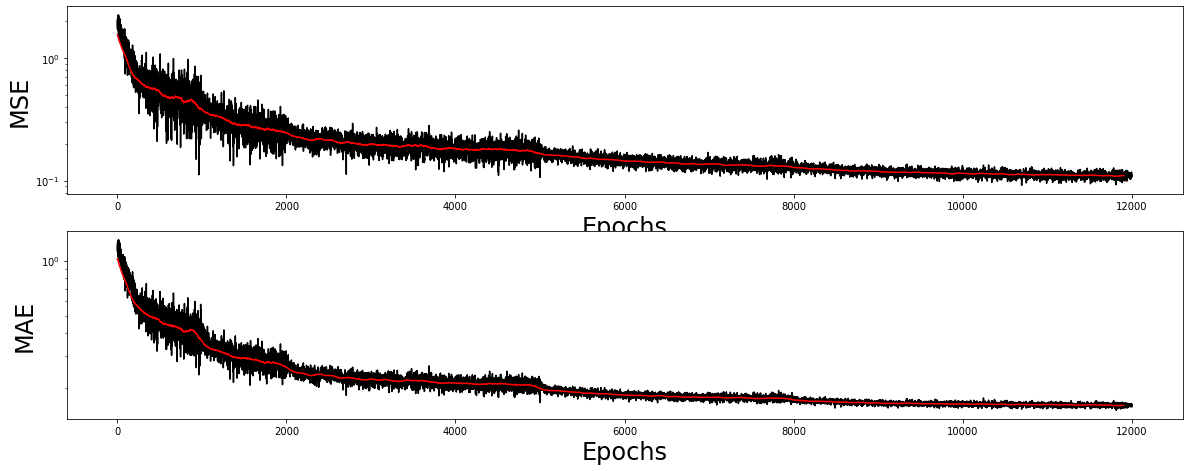

In [8]:
### Plot learning performance

number_of_timesteps_for_average = 100

DeepCalib.plot_learning_performance(training_history, number_of_timesteps_for_average)

## 7. TEST DEEP LEARNING NETWORK ON NEW SIMULATED TRAJECTORIES

The deep learning network is tested on new simulated trajectories (parameters are defined in [section 2](#sec2)). The predicted values of the targets are plotted as function of their ground-truth values both in scaled and physical units.

Comments:
1. The parameter <strong>number_of_predictions_to_show</strong> determines the number of predictions that are shown.

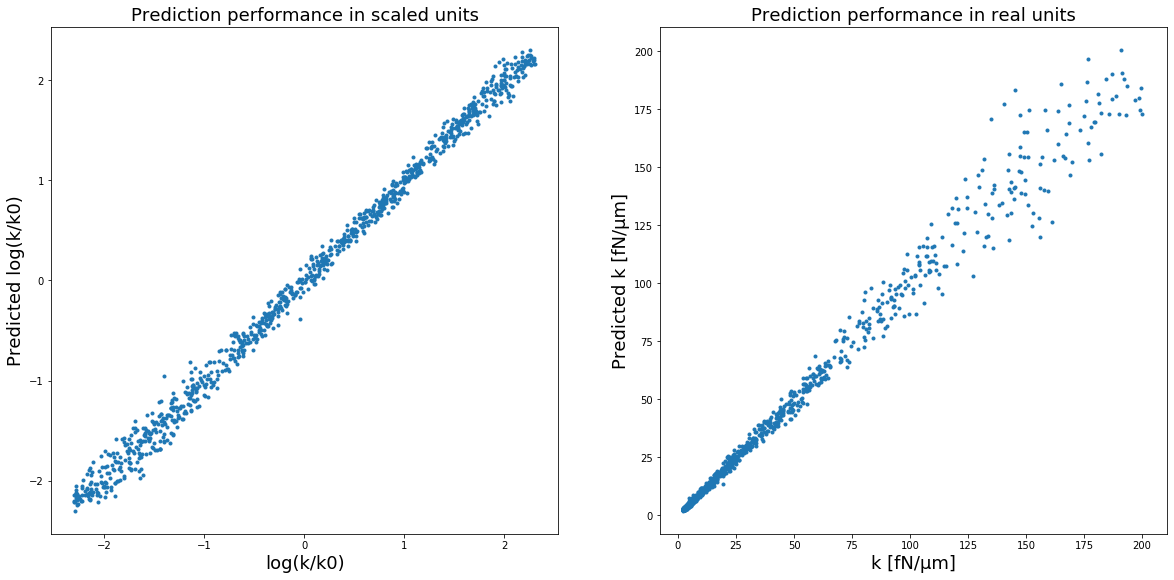

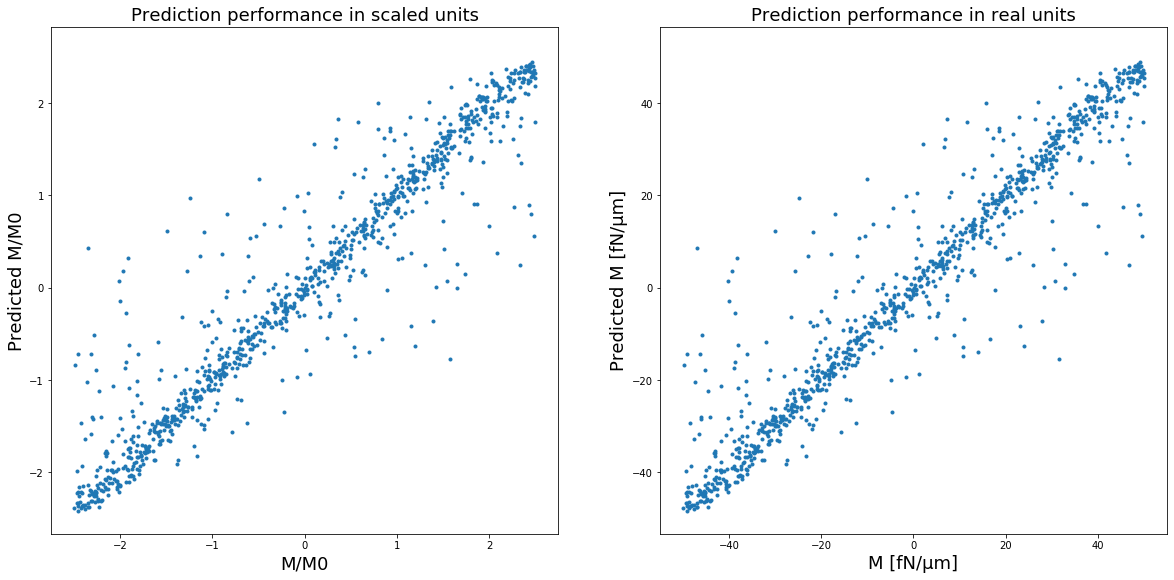

In [13]:
### Test the predictions of the deep learning network on some generated trajectories

number_of_predictions_to_show = 1000

%matplotlib inline
DeepCalib.plot_test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

## 8. SAVE DEEP LEARNING NETWORK

Comments:
1. The parameter <strong>save_file_name</strong> is the name of the file where the deep learnign network is saved.
2. By default, the network is saved in the same folder where DeepCalib is running.

In [10]:
save_file_name = 'Network_Example_3a.h5'
network.save(save_file_name)